In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-04-22 13:55:40.823328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745326541.644510    1814 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745326541.796530    1814 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745326543.165512    1814 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745326543.165557    1814 computation_placer.cc:177] computation placer already registered. 

In [2]:
# Load dataset
dataset = load_dataset("odegiber/hate_speech18", trust_remote_code=True)
df = dataset['train'].to_pandas()

In [3]:
df.head()

,text,user_id,subforum_id,num_contexts,label
0,"As of March 13th , 2014 , the booklet had been...",572066,1346,0,0
1,In order to help increase the booklets downloa...,572066,1346,0,0
2,( Simply copy and paste the following text int...,572066,1346,0,0
3,Click below for a FREE download of a colorfull...,572066,1346,0,1
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,572066,1346,0,0


In [4]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [5]:
df.columns

Index(['text', 'user_id', 'subforum_id', 'num_contexts', 'label'], dtype='object')

In [6]:
df=df.drop(columns=['user_id', 'subforum_id', 'num_contexts'], axis=1)
df.tail()

,text,label
10939,"Billy - `` That guy would n't leave me alone ,...",0
10940,Wish we at least had a Marine Le Pen to vote f...,0
10941,Its like the choices are white genocide candid...,0
10942,Why White people used to say that sex was a si...,1
10943,Now I get it !,0


In [7]:
df = df[(df['label'] == 0) | (df['label'] == 1)]

In [8]:
df['label'].value_counts()

label
0    9465
1    1193
Name: count, dtype: int64

Text(0.5, 1.0, 'Value counts of Target Class')

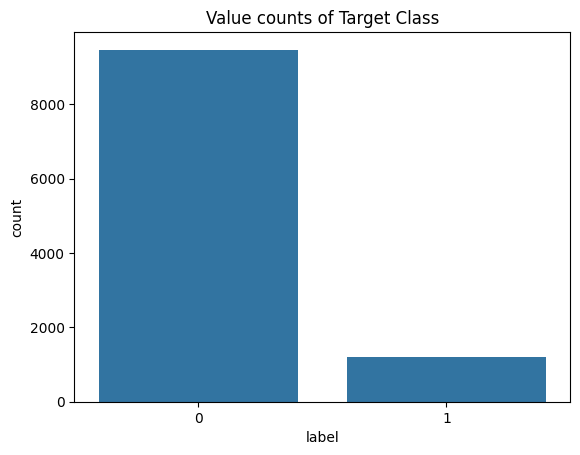

In [9]:
sns.barplot(df['label'].value_counts())
plt.title("Value counts of Target Class")

In [10]:
df.head()

,text,label
0,"As of March 13th , 2014 , the booklet had been...",0
1,In order to help increase the booklets downloa...,0
2,( Simply copy and paste the following text int...,0
3,Click below for a FREE download of a colorfull...,1
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,0


In [17]:
df['text'].describe()

count     10658
unique    10534
top        2508
freq         20
Name: text, dtype: object

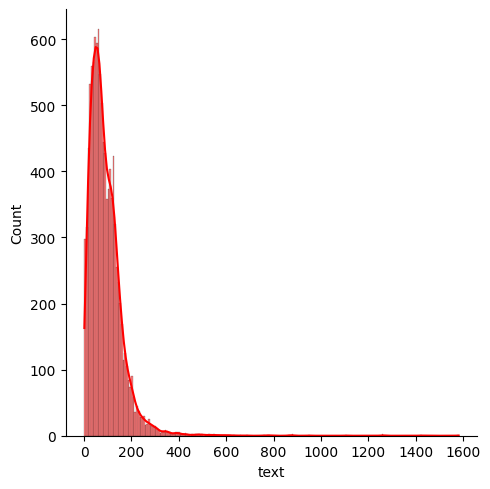

In [16]:
text_lengths = df['text'].apply(len)

sns.displot(text_lengths, kde=True, color= 'red')

In [8]:
# Text preprocessing
stopword = set(stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'&lt;.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    words = text.split()
    words = [word for word in words if word not in stopword]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)
df['clean_text'] = df['text'].apply(clean_text)

In [10]:
# Tokenization and padding
max_num_words = 10000
max_sequence_length = 70
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [11]:
# Label encoding and one-hot encoding
le = LabelEncoder()
y = df['label'].values

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [13]:
# Compute class weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

In [14]:
# Load GloVe Embeddings
embedding_dim = 100
embedding_index = {}

with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((max_num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
model = Sequential([
    Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable= True),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.3)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-21 20:07:57.816140: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


In [18]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.5442 - loss: 1.1517 - val_accuracy: 0.6574 - val_loss: 0.6537
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.7572 - loss: 0.5750 - val_accuracy: 0.7902 - val_loss: 0.4991
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8385 - loss: 0.3754 - val_accuracy: 0.8353 - val_loss: 0.4215
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9093 - loss: 0.2517 - val_accuracy: 0.8465 - val_loss: 0.4112
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9389 - loss: 0.1763 - val_accuracy: 0.8435 - val_loss: 0.4455
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9582 - loss: 0.1302 - val_accuracy: 0.8559 - val_loss: 0.5198
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9686 - loss: 0.1063 - val_accuracy: 0.8739 - val_loss: 0.5153
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9793 - loss: 0.0761 - 

In [19]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8379 - loss: 0.4228
Test Loss: 0.4111749529838562
Test Accuracy: 0.8465290665626526


In [20]:
# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.4).astype("int32").flatten()
y_test_labels = y_test

cm = confusion_matrix(y_test_labels, y_pred_classes)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test_labels, y_pred_classes))

84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Confusion Matrix:
 [[2033  334]
 [ 100  198]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      2367
           1       0.37      0.66      0.48       298

    accuracy                           0.84      2665
   macro avg       0.66      0.76      0.69      2665
weighted avg       0.89      0.84      0.86      2665



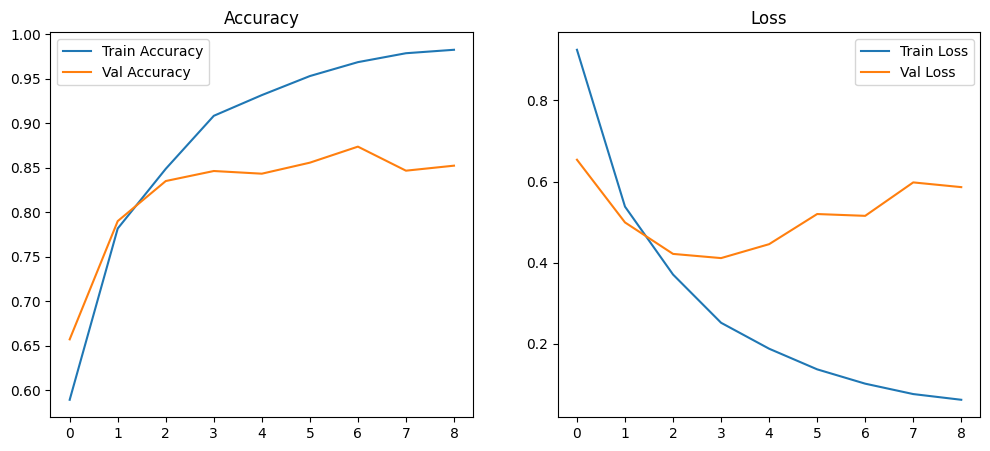

In [21]:
# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [22]:
class_labels=["No Hate", "Hate"]

In [23]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_sequence_length)
    pred = model.predict(padded)
    predicted_index = int(pred[0][0] > 0.4)
    predicted_label = class_labels[predicted_index]
    print("\n📊 Class probabilities:")
    print(f"  No Hate: {1 - pred[0][0]:.4f}")
    print(f"  Hate:    {pred[0][0]:.4f}")
    return f"\n🧠 Predicted class: {predicted_label} (index: {predicted_index})"


In [24]:
print(df[df["label"]==1].sample(5)["text"].values[0])

They are culturally raping european countries in every way .


In [38]:
# Example usage

custom_input = "Beautiful Sweden poisoned by subhuman trash"
print("Predicted class:", predict_text(custom_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

📊 Class probabilities:
  No Hate: 0.0744
  Hate:    0.9256
Predicted class: 
🧠 Predicted class: Hate (index: 1)
